# Summary

## TODO

1. hyperparam optimization 

In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [2]:
import xgboost as xgb
import shap
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.stats import zscore, binned_statistic
from scipy.ndimage import gaussian_filter1d

from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer
from hyperopt import tpe, Trials, fmin, hp, STATUS_OK

In [3]:
# full, no imp
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

%memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))

loaded @200713.10:45:33
took 11.77-s to load data
peak memory: 10807.38 MiB, increment: 10595.80 MiB


In [4]:
utils.pklthat(adata.var_names.to_list(), os.path.join(pdfp, 'scnd_feat_names.pkl'))

saved @200713.10:45:33


In [7]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

%memit wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))
%memit mutt = utils.load_adata(os.path.join(pdfp, 'mouse_sca1_imputed.h5ad'))

loaded @200707.09:48:43
took 40.61-s to load data
peak memory: 38674.76 MiB, increment: 38462.45 MiB
loaded @200707.09:49:40
took 57.56-s to load data
peak memory: 74524.80 MiB, increment: 35857.52 MiB


# Hyperparam optimization 

Choose params on WT PC, apply to all

In [4]:
# get the data
for ctype in ['Purkinje cell']:#[i for i in adata.obs['ctype'].unique() if 'Granule' not in i and 'Bergmann' not in i]:#[i for i in adata.obs['ctype'].unique() if 'Granule' not in i]:
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = adata.obs.loc[(adata.obs['ctype']==ctype), :].sample(75000).index.to_list()
            wt = adata[(adata.obs['ctype']==ctype) & (adata.obs['genotype']=='WT') & (adata.obs.index.isin(nsample_idx))]
            mut = adata[(adata.obs['ctype']==ctype) & (adata.obs['genotype']=='SCA1') & (adata.obs.index.isin(nsample_idx))]
        else:
            wt = adata[(adata.obs['ctype']==ctype) & (adata.obs['genotype']=='WT')]
            mut = adata[(adata.obs['ctype']==ctype) & (adata.obs['genotype']=='SCA1')]

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        # strata
        X = pd.DataFrame(wt.X.todense(), columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()


Starting Purkinje cell
----

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03)
computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [5]:
# hyperopt

# hyperopt 
def objective(hyperparameters):
    '''Objective function to evaluate sequential based model optimiatization via `hyperopt`.
    
    This function will be called by `hyperopt.fmin` with a value generated from `space`
    as the first arg.  It can return either a scalar-valued loss, or a dictionary.  
    
    NOTE: A returned dictionary must contain a 'status' key with a value from `STATUS_STRINGS`,  
        and a 'loss' key if the status is `STATUS_OK`.
                  
    Args: 
        hyperparameters (dict): set to optimize
        params (dict, GLOBAL): set of params in model to fix; globally set to avoid `hyperot` 
            errors.
        int_parms (list, GLOBAL): list of parameters to check to make sure 
            globally set to avoid `hyperot` errors.
        
    Returns:
        dict: with loss value for objective function specified in body and status flag
    '''
    start = timer()
        
#     ITERATION += 1
    
    if INT_PARAMS is not None:
        # Make sure parameters that need to be integers are integers
        for parameter_name in INT_PARAMS:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    # merge parameters 
    trial_params = {**hyperparameters, **PARAMS}

    if False:
        # by xgb.cv
        metric = 'auc'
        xgb_optim = xgb.cv(
            trial_params, 
            dtrain, 
            num_boost_round=100,
            nfold=5,
            metrics={metric},
            early_stopping_rounds=10)
        best_score = xgb_optim.sort_values(by='test-{}-mean'.format(metric),ascending=False)
        best_score = best_score['test-{}-mean'.format(metric)].iloc[0]
        
    elif True:
        # by custom CV (take best so consistent with bootstrapping)
        
        # cv
        kfolds = 10
        kf = KFold(n_splits=kfolds, shuffle=True)
        
        num_round = 5000
        early_stopping = 100
        
        eval_metric = []
        for idx_train, idx_val in kf.split(X):
            X_train_cv, X_val = X.iloc[idx_train,:], X.iloc[idx_val,:]
            y_train_cv, y_val = y[idx_train], y[idx_val]
                
            dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
            dval = xgb.DMatrix(X_val, label=y_val)
            
            estimator = xgb.train(
                trial_params,
                dtrain,
                num_boost_round=num_round,
                evals=[(dtrain,'train'), (dval, 'val')],
                verbose_eval=False,
                early_stopping_rounds=early_stopping)
            eval_metric.append(estimator.best_score)
        best_score = np.max(eval_metric)
        
    else:
        # similar to eval step 
        num_round = 20
        early_stopping = 10

        model = xgb.train(
            trial_params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dtest, 'test')],
            early_stopping_rounds=early_stopping,
            verbose_eval = num_round,
        )
        best_score = model.best_score

    # loss fx
    loss = best_score # 1 - AUC, here want to minimize RMSE
    
    run_time = timer() - start
    
    if False :
        # Write to the csv file ('a' means append)
        of_connection = open(OUT_FILE, 'a')
        writer = csv.writer(of_connection)
        writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
        of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# fixed params
PARAMS = {
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    'verbosity':0,

    'booster':'gbtree', # default='gbtree',
#     'eta':0.1, # default=0.1, set initially high, decrease later
#     'max_depth':3, # default = 0.6 
#     'min_child_weight': 1, # default = 1
#     'max_delta_step':1, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
#     'subsample': 0.8, # default=1
#     'colsample_bytree': 0.8, # default=1, can set others
#     'alpha':0.1, # defualt=0
#     'lamda':0.1, # default=0
#     'scale_pos_weight':np.sum(y_test==0) / np.sum(y_test==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

    # learning
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
} 


# define bayesian domain
space = {'eta':hp.loguniform('eta',np.log(1e-5),np.log(0.3)),
         'max_depth':hp.quniform('max_depth',1,1000,1),
         'min_child_weight':hp.quniform('min_child_weight',1,100,1),
         'max_delta_step':hp.quniform('max_delta_step',0,100,1),
         'scale_pos_weight':hp.quniform('scale_pos_weight',0,100,1),
         'gamma':hp.uniform('gamma',0,100),
         'subsample':hp.uniform('subsample',0,1),
         'alpha':hp.uniform('alpha',0,1),
         'lamda':hp.uniform('lamda',0,1),
         'colsample_bytree':hp.uniform('colsample_bytree',0,1),
         'colsample_bylevel':hp.uniform('colsampple_bylevel',0,1),
         'colsample_bynode':hp.uniform('colsample_bynode',0,1),
        }


INT_PARAMS = ['max_depth','min_child_weight','max_delta_step']


###################################################



max_evals = 100
ITERATION = 0

In [ ]:
# run hyperopt 
trials = Trials() # record results

global INT_PARAMS
global PARAMS

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = max_evals)

if True:
    # save trials neatly
    hyperparam_opt = pd.DataFrame(trials.results).sort_values(by='loss',ascending=True)
    hyperparam_opt.to_csv(os.path.join(pfp,'{}_{}hyperopt.csv'.format(model_name,method)))
    

# display output
## w/o trials class, # print('\n best trial:\n  {}'.format(trials.best_trial))
print('hyperopt results')
for i in range(1): # print top n
    for k,v in hyperparam_opt.iloc[i,1].items():
        if isinstance(v,str):
            print('{}\t{}'.format(k,v))
        else:
            print('{}\t{:.8f}'.format(k,v))

  5%|▍         | 49/1000 [18:10:42<110:41:51, 419.04s/trial, best loss: 0.118791] 

# Principled params

In [6]:
# get the data
sns.set(font_scale=0.33)
ntop = 500
ntimebins = 20
n_bootstraps = 1 
kfolds = 10
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['Astrocyte', 'Oligodendrocyte', 'Unipolar brush cell', 'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 'Endothelial cell', 'Pericyte', 'Purkinje cell', 'GABAergic interneuron 3', 'Oligodendrocyte progenitor cell', 'Granule cell']):
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # bootstraps
    print('\n  starting WT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            params = {
                'verbosity': 0, 
                'validate_parameters': False,
                'eta': 0.3,  # default=0.3
                'gamma':0, # default=0
                'max_depth':100, # default=6
                'min_child_weight':5, # default=1
                'max_delta_step':0, # default=0
                'subsample':0.8, # default=0
                'sampling_method':'uniform', # default='uniform'
                'colsample_bytree':0.25, # default=1
                'colsample_bylevel':0.25, # default=1
                'colsample_bynode':0.25, # default=1
                'lambda':1, # default=1
                'alpha':0, # default=
                'scale_pos_weight':1, # default=1

                'objective':'reg:squarederror',
                'eval_metric':'rmse',
            }

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt = pd.DataFrame({'r2_wt':cv_eval, 'ctype':[ctype]*len(cv_eval)})
        print('\n  bst WT CV: {}\n'.format(np.max(cv_eval)))

    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)   

    # topn in WT, standardize in cell type and genotype 
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y']+mito_genes), :]
    topgenes = data.iloc[0:ntop, :].index.to_list() # add to this topgenes list with other model 
    
    # MUT model
    del X, y
    X = pd.DataFrame(mut.layers['imputed'], columns=mut.var_names.to_list())
    y = mut.obs['ees_t'].to_numpy()
    
    # bootstraps
    print('\n  starting MUT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt['r2_mut'] = cv_eval
        performance = performance.append(dt, ignore_index=True)
        print('\n  bst MUT CV: {}\n'.format(np.max(cv_eval)))
        performance.to_csv(os.path.join(pfp, 'top{}_dyngenes_performance.csv'.format(ntop)))
        
    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)       
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y']+mito_genes), :]
    wttop = topgenes 
    muttop = data.iloc[0:ntop, :].index.to_list() # save these and perhaps RMSE data
    topgenes = list(set(wttop + muttop)) 

    # topn, specify how to normalize
    norm_ctypeANDcondition = False
    
    if norm_ctypeANDcondition: # plot both for now
        x = pd.DataFrame(wt[:, topgenes].X.todense(), columns=topgenes)
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])
        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}.png'.format(ctype)))

        # plot same genes in mut
        mut_goi = x.index[p.dendrogram_row.reordered_ind].to_list() # in order of previous tree
        x_mut = pd.DataFrame(mut[:, mut_goi].X.todense(), columns=mut_goi)
        x_mut.loc[:, mut_goi] = zscore(x_mut.loc[:, mut_goi])
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}.png'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 14), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}.png'.format(ctype)))
        
    else: # plot both for now
        # topn in WT, standardize in cell type ONLY
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['ctype'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['ctype'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50),
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}_ctypeNORM.pdf'.format(ctype)))

        # plot same genes in mut
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}_ctypeNORM.pdf'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 50), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
                vmax=1, vmin=-1,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))
        
        x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
                    x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
                    fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
                    order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
                    y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
                    label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
        fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        fig, ax = plt.subplots(1,1, figsize=(4,3))
        z = x_diff.abs().mean(axis=0).reset_index()
        z = z.rename(columns={0:'ave_mut-wt'})

        # histogram
        sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )
        ax.plot(z['time_grouping']-1, yprime, color='gray')
        ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
        fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        x_diff = x_diff.reset_index()
        x_diff['ctype'] = ctype
        x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
        x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val

        results = results.append(x_diff, ignore_index=True)

        # intermediate save
        if verbose: # save every round
            results.to_csv(os.path.join(pfp,'top{}_dyngenes_v2.csv'.format(ntop)))
    
    print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))
    
results.to_csv(os.path.join(pfp,'top{}_dyngenes.csv'.format(ntop)))


Trying to set attribute `.obs` of view, copying.



Starting Astrocyte
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:28)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:06)
computing PCA
    with n_comps=50
    finished (0:00:28)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)

  starting WT model training

[0]	train-rmse:0.17963	CV1-rmse:0.18164
Multiple eval metrics have been passed: 'CV1-rmse' will be used for early stopping.

Will train until CV1-rmse hasn't improved in 500 rounds.
[500]	train-rmse:0.00026	CV1-rmse:0.06789
Stopping. Best iteration:
[43]	train-rmse:0.00181	CV1-rmse:0.06784

[0]	train-rmse:0.17994	CV2-rmse:0.18227
Multiple eval metrics have been passed: 'CV2-rmse' will be used for early stopping.

Will train until CV2-rmse hasn't improved in 500 rounds.
[500]	train-rmse:0.00027	CV2-rmse:0.05194
Stopping. Best iteration:
[28]	train-rmse:0.00284	CV2-rmse:0.05191

[0]	train-rmse:0.17850	CV3-rmse:0.19494
Multiple eval metrics have been passed: 'CV3-rmse' will be used for early sto

NameError: name 'topn' is not defined

In [ ]:
# plot all genes

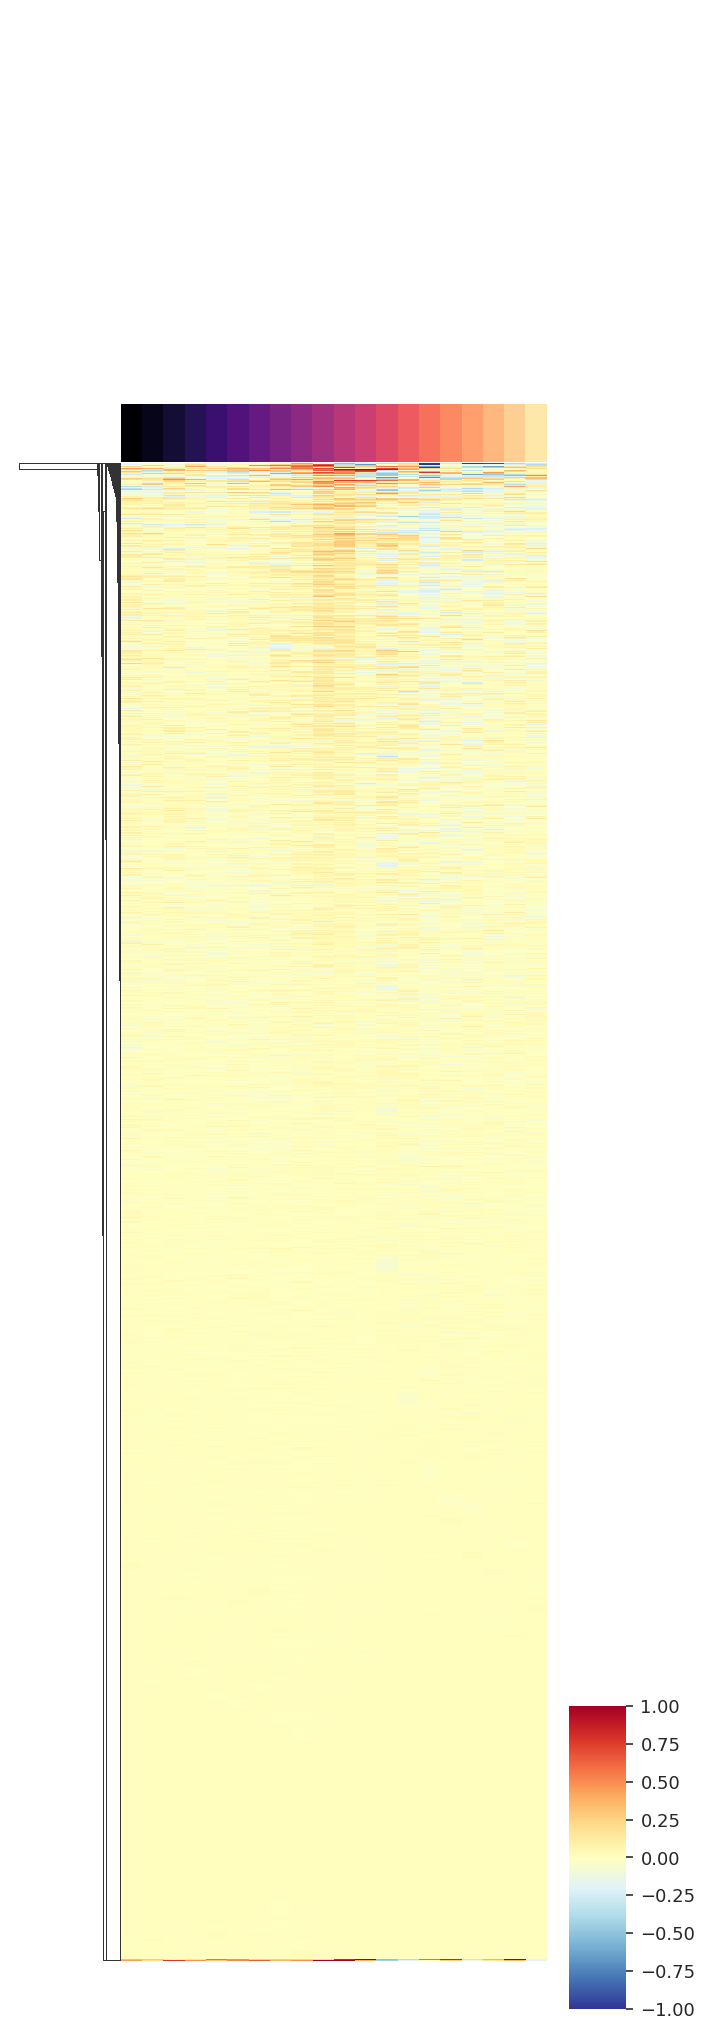

In [37]:
# OLD VERSION, SEE imputation_by_genotime.ipynb for up to date 

# # plot all diff
# sys.setrecursionlimit(10000)
# x = pd.DataFrame(adata.X.todense(), 
#                  columns=adata.var_names.to_list(),
#                  index=adata.obs.index.to_list())
# x['ctype'] = adata.obs['ctype'].to_list()
# x = x.loc[x['ctype']==ctype, :]
# x = x.drop(columns='ctype')
# x.loc[:, topgenes] = zscore(x.loc[:,topgenes])

# # subset
# x_mut = x.loc[mut.obs.index]
# x = x.loc[wt.obs.index]

# _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
#                                         np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
# x['time_grouping'] = time_groupings[0:wt.shape[0]]
# x = x.groupby('time_grouping').mean().T

# cm = plt.get_cmap('magma')
# timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

# # plot same genes in mut
# x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
# x_mut = x_mut.groupby('time_grouping').mean().T

# x_diff  = x_mut.subtract(x) # MUT - WT
# p_diff = sns.clustermap(
#         x_diff,
#         pivot_kws=None,
#         method='average',
#         metric='euclidean',
#         z_score=None,
#         standard_scale=None,
#         row_cluster=True,
#         col_cluster=False,
#         row_linkage=None,
#         figsize=(4, 14), 
#         col_linkage=None,
#         row_colors=None,
#         col_colors=timecolors,
#         mask=None,
#         dendrogram_ratio=0.2,
#         colors_ratio=0.03,
#         cbar_pos=(1, 0, 0.1, 0.15),
#         tree_kws=None,
#         cmap='RdYlBu_r',
#         yticklabels=False,
#         xticklabels=False,
#         vmin=-1, vmax=1,
#     )
# p_diff.ax_heatmap.set_xlabel('')

# p_diff.savefig(os.path.join(pfp, 'ALL_genes_DIFF_{}_ctypeNORM.png'.format(ctype)))

In [8]:
# get the data
sns.set(font_scale=0.33)
ntop = 500
ntimebins = 20
n_bootstraps = 1 
kfolds = 10
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['Purkinje cell']):
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # bootstraps
    print('\n  starting WT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            params = {
                'verbosity': 0, 
                'validate_parameters': False,
                'eta': 0.3,  # default=0.3
                'gamma':0, # default=0
                'max_depth':100, # default=6
                'min_child_weight':5, # default=1
                'max_delta_step':0, # default=0
                'subsample':0.8, # default=0
                'sampling_method':'uniform', # default='uniform'
                'colsample_bytree':0.25, # default=1
                'colsample_bylevel':0.25, # default=1
                'colsample_bynode':0.25, # default=1
                'lambda':1, # default=1
                'alpha':0, # default=
                'scale_pos_weight':1, # default=1

                'objective':'reg:squarederror',
                'eval_metric':'rmse',
            }

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt = pd.DataFrame({'r2_wt':cv_eval, 'ctype':[ctype]*len(cv_eval)})
        print('\n  bst WT CV: {}\n'.format(np.max(cv_eval)))

    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)   

    # topn in WT, standardize in cell type and genotype 
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y']+mito_genes), :]
    topgenes = data.iloc[0:ntop, :].index.to_list() # add to this topgenes list with other model 
   

Trying to set attribute `.obs` of view, copying.



Starting Purkinje cell
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:05)
computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)

  starting WT model training

[0]	train-rmse:0.17369	CV1-rmse:0.17056
Multiple eval metrics have been passed: 'CV1-rmse' will be used for early stopping.

Will train until CV1-rmse hasn't improved in 500 rounds.
[500]	train-rmse:0.00026	CV1-rmse:0.06876
Stopping. Best iteration:
[164]	train-rmse:0.00028	CV1-rmse:0.06876

[0]	train-rmse:0.17245	CV2-rmse:0.18744
Multiple eval metrics have been passed: 'CV2-rmse' will be used for early stopping.

Will train until CV2-rmse hasn't improved in 500 rounds.
[500]	train-rmse:0.00027	CV2-rmse:0.05066
Stopping. Best iteration:
[71]	train-rmse:0.00055	CV2-rmse:0.05061

[0]	train-rmse:0.17416	CV3-rmse:0.16863
Multiple eval metrics have been passed: 'CV3-rmse' will be used for early st

In [12]:
data

,score
Gm15856,8.637598
Gm26848,7.627218
Cacna1a,4.216375
Prtg,4.199797
Setmar,3.501208
...,...
Avp,0.000001
Recql,0.000001
Lyrm2,0.000001
Gm20463,0.000001


In [21]:
x1 = data.iloc[0:10, 0].to_dict()
x2 = data.iloc[10:20, 0].to_dict()
d = data.reset_index()
d['top_wt'] = d['index']
d['wt_score'] = d['top_wt'].map(x1)

In [22]:
d

,index,score,top_wt,wt_score
0,Gm15856,8.637598,Gm15856,8.637598
1,Gm26848,7.627218,Gm26848,7.627218
2,Cacna1a,4.216375,Cacna1a,4.216375
3,Prtg,4.199797,Prtg,4.199797
4,Setmar,3.501208,Setmar,3.501208
...,...,...,...,...
4331,Avp,0.000001,Avp,NaN
4332,Recql,0.000001,Recql,NaN
4333,Lyrm2,0.000001,Lyrm2,NaN
4334,Gm20463,0.000001,Gm20463,NaN
